In [1]:
# 필요한 모든 라이브러리를 불러옵니다.
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input
from keras.models import Sequential
from keras.layers import GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import dot
from keras.layers import BatchNormalization
from keras.layers import concatenate
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
import warnings
from pykrx import stock
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 경고 메시지를 피하기 위해 warnings method를 사용합니다.
warnings.filterwarnings('ignore')

In [3]:
# 한국전력공사 데이터를 불러옵니다.
Kepco = stock.get_market_ohlcv_by_date(fromdate="20110101", todate="20211210", ticker="015760")

In [4]:
Kepco

,시가,고가,저가,종가,거래량
날짜,,,,,
2011-01-03,30400,30450,29800,30050,1261721
2011-01-04,30050,30050,29700,29900,1718372
2011-01-05,29800,29850,29200,29250,2324148
2011-01-06,29350,29650,29050,29050,1930250
2011-01-07,29000,29050,28650,28950,2077771
...,...,...,...,...,...
2021-12-06,21650,21800,21300,21650,967295
2021-12-07,21700,22000,21600,21900,943397
2021-12-08,22000,22450,21950,22200,1645576


In [5]:
# Diagnose whether there are null data 
Kepco.isnull().sum()

시가     0
고가     0
저가     0
종가     0
거래량    0
dtype: int64

In [6]:
# 2011-01-03일부터 2021-12-10일까지 3994일이다. 그런데 데이터에는 2697일 밖에 없다.
# 주말이 빠졌기 때문이다. 그래서 일주일을 7일이 아닌 5일로 봐야한다.
# 그래서 4주도 28일이 아닌 20일로 봐야한다. 즉, 한달을 20일로 볼 수 있다는 의미다.
from datetime import datetime
time_first=datetime(2011,1,3)
time_last = datetime(2021,12,10)
print(time_last - time_first)
print(Kepco.shape[0])

3994 days, 0:00:00
2697


In [7]:
# 각 성분별 그래프를 그립니다.
# interact 함수를 사용했습니다.
def f(col):
    col_value=Kepco[col]
    plt.plot(col_value)
interact(f, col=list(Kepco.columns))

interactive(children=(Dropdown(description='col', options=('시가', '고가', '저가', '종가', '거래량'), value='시가'), Output…

<function __main__.f(col)>

In [8]:
# 다음과 같이 train과 test를 나눈다.
train_ratio = 0.7
train_len = int(train_ratio * Kepco.shape[0])
train_stock = Kepco[:train_len]
test_stock = Kepco[train_len:]

In [9]:
# 이제 각 열(시가, 고가 등등)별로 MinMaxScaler를 구한다.
# 또한 train 데이터에 이 scaler를 적용한다.
train = train_stock.copy()
scalers = {}
for i in train_stock.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    scalers['scaler_'+i]=scaler
    train[i] = s_s

In [10]:
#scalers에는 다음과 같이 5종류의 MinMaxScaler가 담겨있다.
scalers

{'scaler_시가': MinMaxScaler(feature_range=(-1, 1)),
 'scaler_고가': MinMaxScaler(feature_range=(-1, 1)),
 'scaler_저가': MinMaxScaler(feature_range=(-1, 1)),
 'scaler_종가': MinMaxScaler(feature_range=(-1, 1)),
 'scaler_거래량': MinMaxScaler(feature_range=(-1, 1))}

In [11]:
# test도 마찬가지다.
test = test_stock.copy()
for i in train_stock.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    test[i] = s_s

In [12]:
# 다음은 데이터를 시계열 데이터로 만드는 함수이다.
# target_col 인자에는 지금은 모든 열을 대상으로 했지만 언제든 변화가 가능하다.
def split_series(series, n_past,n_future,target_col=list(range(len(Kepco.columns)))):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        past, future = series[window_start:past_end,:], series[past_end:future_end,target_col]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)
            

## LSTM 

In [13]:
train.shape

(1887, 5)

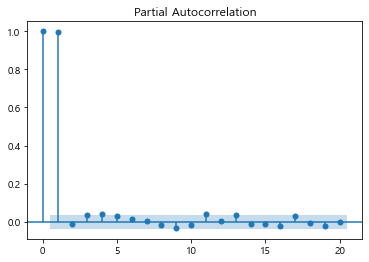

In [14]:
# 종가의 pacf를 그려본다. 그렇게 큰 의미는 없어보인다. 그래서 과거 데이터를
# 임의로 잡으려 한다.
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(Kepco.iloc[:,3], lags = 20);


In [15]:
# n_feature는 데이터의 열 개수이다.
# 저는 한달치 데이터(주말을 제외한 20일)을 사용하려 합니다.
n_features = train.shape[1] # 5
n_past = 20
n_future = 1

In [16]:
# target_col에 '종가' index를 대입하여 
X_train, y_train = split_series(train.values,n_past,n_future, target_col=Kepco.columns.get_loc('종가'))

In [17]:
# 잘 분해되었는지 한 번 살펴본다.
print(X_train.shape); print(y_train.shape)

(1867, 20, 5)
(1867, 1)


In [18]:
# 여기서 주의할 점! test를 그대로 쓸 것이 아니라 train 데이터의 뒤에서 n_past만큼
# 떼서 test와 합쳐야 한다.
# 그래야 test의 첫 번째 종가부터 예측을 할 수 있다.
test_lstm = pd.concat([train[-n_past:],test])

In [19]:
# Test 데이터를 만듭니다.
X_test, y_test = split_series(test_lstm.values, n_past,n_future, target_col=Kepco.columns.get_loc('종가') )

In [20]:
print(X_test.shape); print(y_test.shape)

(810, 20, 5)
(810, 1)


## Grid Search on LSTM

In [21]:
# GridSearch때 사용할 kfold를 만듭니다.
kfold= KFold(n_splits=3)

In [22]:
# LSTM의 neurouns를 hyperparameter로 설정한 뒤 다음과 같은 함수를 작성한다.
# 이 함수는 뒤에서 RandomizedSearchCV를 사용할 때 대상이 된다.
# neuron 갯수의 후보는 아래와 같습니다.
def build_model(n_neurons):
    model = Sequential()
    model.add(LSTM(units=n_neurons, activation='tanh', input_shape=(n_past, n_features)))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mse',optimizer=tf.keras.optimizers.RMSprop(0.001), metrics=['mse'])
    return model
n_neurons = [10, 20, 30]
param_grid = dict(n_neurons=n_neurons)

In [23]:
# KerasRegressor를 장착한 채로 RandomizedSearch CV를 해야합니다.
model_candi = KerasRegressor(build_fn = build_model)

In [24]:
grid_lstm = RandomizedSearchCV(estimator=model_candi, cv=kfold, param_distributions=param_grid)

In [ ]:
# GridSearch를 시행합니다.
grid_lstm.fit(X_train, y_train, epochs=50, batch_size=20, verbose=0)

20/20 [==============================] - 0s 2ms/step - loss: 0.0053 - mse: 0.0053


In [ ]:
# 가장 좋은 파라미터는 다음과 같습니다. 
print(grid_lstm.best_params_)

In [ ]:
best_lstm =grid_lstm.best_estimator_

In [ ]:
# best한 lstm으로 다시 훈련을 합니다. validation loss도 같이 구합니다.
# 시간 단축을 위해 모든 epoch를 50으로 했습니다.
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
history_lstm = best_lstm.fit(X_train, y_train, epochs=50, batch_size=20, validation_split=0.2, callbacks=[es],
                            verbose=0)

In [577]:
train_mse = history_lstm.history['mse']
valid_mse = history_lstm.history['val_mse']

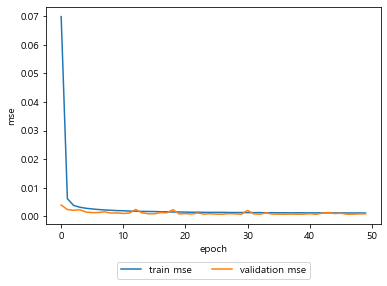

In [578]:
# train_mse와 validation mse를 아래와 같이 그릴 수 있습니다.
plt.plot(train_mse, label='train mse')
plt.plot(valid_mse, label='validation mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.15), fancybox=True, shadow=False, ncol=2)

## 예측 평가 LSTM(MSE, MAPE)

In [579]:
# 예측하고 inverse를 이용해 아래와 같이 구합니다.
pred_lstm = best_lstm.predict(X_test).reshape(-1,1)
scaler_close = scalers['scaler_종가']
pred_lstm = scaler_close.inverse_transform(pred_lstm)
y_test = scaler_close.inverse_transform(y_test)

In [580]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
mse_lstm = mean_squared_error(y_test, pred_lstm)
mape_lstm = mean_absolute_percentage_error(y_test, pred_lstm)


In [581]:
# mse와 mape는 다음과 같습니다.
print(mse_lstm); print(mape_lstm)

780117.9912565207
0.02733720565667474


## Predict the future 5 days using standard Seq2Seq Model

In [582]:
# LSTM과 달라진 점 중 하나는 n_future가 5라는 것입니다.
n_past= 20
n_features = train.shape[1]
n_future = 5

In [583]:
# LSTM때는 '종가'만이 target data였는데 여기선 시가 종가 거래량 등 모든 것을 예측할 것입니다.
X_train, y_train = split_series(series=train.values,n_past=n_past, n_future=n_future, target_col=list(range(len(Kepco.columns))))

In [584]:
print(X_train.shape); print(y_train.shape)

(1863, 20, 5)
(1863, 5, 5)


In [585]:
# 여기서도 test 데이터를 만들 때 train 데이터의 뒷부분을 떼서 test와 합칩니다.
test_seq2 = pd.concat([train[-n_past:],test])

In [586]:
test_seq2.shape

(830, 5)

In [587]:
X_test, y_test = split_series(series=test_seq2.values,n_past=n_past, n_future=n_future, target_col=list(range(len(Kepco.columns))))

In [588]:
print(X_test.shape); print(y_test.shape)

(806, 20, 5)
(806, 5, 5)


## Grid Search on Seq2Seq2

In [589]:
# Encoder1Decoder1을 이용할 것입니다.
#LSTM때와 마찬가지로 GridSearch를 위해 다음과 같은 함수를 작성합니다. 
# 여기선 뉴런수가 대상이 아닌 activation function이 대상입니다. 
def build_e1d1(activation):
    input_train = Input(shape=(n_past,n_features))
    output_train = Input(shape=(n_future,n_features))
    encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
    100, return_sequences=False, return_state=True, activation=activation)(input_train)
    encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
    encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)
    decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
    decoder = LSTM(100, activation=activation,return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])
    out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
    model = Model(inputs=input_train, outputs=out)
    opt = Adam(learning_rate=0.01)
    model.compile(loss='mse', optimizer=opt, metrics=['mse'])
    return model
    
    

In [590]:
# elu와 relu가 후보입니다.
activation = ['elu','relu']
param_grid = dict(activation=activation)

In [591]:
param_grid

{'activation': ['elu', 'relu']}

In [592]:
model_seq2 = KerasRegressor(build_fn=build_e1d1)
grid_seq2 = RandomizedSearchCV(estimator=model_seq2, cv=kfold, param_distributions=param_grid)

In [593]:
grid_seq2.fit(X_train, y_train, epochs=50)

Epoch 1/50
39/39 [==============================] - 2s 13ms/step - loss: 0.2174 - mse: 0.2174
Epoch 2/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0123 - mse: 0.0123
Epoch 3/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0113 - mse: 0.0113
Epoch 4/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0090 - mse: 0.0090
Epoch 5/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0080 - mse: 0.0080
Epoch 6/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0077 - mse: 0.0077
Epoch 7/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0067 - mse: 0.0067
Epoch 8/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0069 - mse: 0.0069
Epoch 9/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0075 - mse: 0.0075
Epoch 10/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0065 - mse: 0.0065
Epoch 11/50
39/39 [==============================] - 1s 14m

39/39 [==============================] - 1s 17ms/step - loss: 0.0045 - mse: 0.0045
Epoch 21/50
39/39 [==============================] - 1s 15ms/step - loss: 0.0042 - mse: 0.0042
Epoch 22/50
39/39 [==============================] - 1s 15ms/step - loss: 0.0041 - mse: 0.0041
Epoch 23/50
39/39 [==============================] - 1s 15ms/step - loss: 0.0042 - mse: 0.0042
Epoch 24/50
39/39 [==============================] - 1s 16ms/step - loss: 0.0044 - mse: 0.0044
Epoch 25/50
39/39 [==============================] - 1s 15ms/step - loss: 0.0048 - mse: 0.0048
Epoch 26/50
39/39 [==============================] - 1s 15ms/step - loss: 0.0052 - mse: 0.0052
Epoch 27/50
39/39 [==============================] - 1s 17ms/step - loss: 0.0045 - mse: 0.0045
Epoch 28/50
39/39 [==============================] - 1s 17ms/step - loss: 0.0041 - mse: 0.0041
Epoch 29/50
39/39 [==============================] - 1s 16ms/step - loss: 0.0043 - mse: 0.0043
Epoch 30/50
39/39 [==============================] - 1s 16ms/s

59/59 [==============================] - 1s 23ms/step - loss: 0.0043 - mse: 0.0043
Epoch 40/50
59/59 [==============================] - 1s 21ms/step - loss: 0.0046 - mse: 0.0046
Epoch 41/50
59/59 [==============================] - 1s 23ms/step - loss: 0.0040 - mse: 0.0040
Epoch 42/50
59/59 [==============================] - 1s 22ms/step - loss: 0.0040 - mse: 0.0040
Epoch 43/50
59/59 [==============================] - 1s 23ms/step - loss: 0.0043 - mse: 0.0043
Epoch 44/50
59/59 [==============================] - 1s 22ms/step - loss: 0.0042 - mse: 0.0042
Epoch 45/50
59/59 [==============================] - 1s 22ms/step - loss: 0.0045 - mse: 0.0045
Epoch 46/50
59/59 [==============================] - 1s 25ms/step - loss: 0.0049 - mse: 0.0049
Epoch 47/50
59/59 [==============================] - 1s 25ms/step - loss: 0.0051 - mse: 0.0051
Epoch 48/50
59/59 [==============================] - 1s 24ms/step - loss: 0.0042 - mse: 0.0042
Epoch 49/50
59/59 [==============================] - 1s 25ms/s

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000001B49D698880>,
                   param_distributions={'activation': ['elu', 'relu']})

In [594]:
#'relu'가 최적이라고 나옵니다.
grid_seq2.best_params_

{'activation': 'relu'}

In [596]:
best_seq2 = grid_seq2.best_estimator_
es =EarlyStopping(monitor='val_loss', mode='min', patience=5)
history_seq2 = best_seq2.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[es],
                            verbose=0)

Epoch 1/50
47/47 [==============================] - 2s 19ms/step - loss: 0.1263 - mse: 0.1263 - val_loss: 0.0249 - val_mse: 0.0249
Epoch 2/50
47/47 [==============================] - 1s 14ms/step - loss: 0.0199 - mse: 0.0199 - val_loss: 66230.5547 - val_mse: 66230.5625
Epoch 3/50
47/47 [==============================] - 1s 15ms/step - loss: 0.0166 - mse: 0.0166 - val_loss: 0.0231 - val_mse: 0.0231
Epoch 4/50
47/47 [==============================] - 1s 15ms/step - loss: 0.0148 - mse: 0.0148 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 5/50
47/47 [==============================] - 1s 15ms/step - loss: 0.0138 - mse: 0.0138 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 6/50
47/47 [==============================] - 1s 15ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 7/50
47/47 [==============================] - 1s 15ms/step - loss: 0.0205 - mse: 0.0205 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 8/50
47/47 [==============================] - 1s 15ms/step - loss: 0.

In [426]:
es =EarlyStopping(monitor='val_loss', mode='min', patience=50)

In [427]:
history_seq2 = best_seq2.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[es],
                            verbose=0)

Epoch 1/50
47/47 [==============================] - 2s 19ms/step - loss: 0.1597 - mae: 0.2116 - val_loss: 0.0065 - val_mae: 0.0621
Epoch 2/50
47/47 [==============================] - 1s 14ms/step - loss: 0.0146 - mae: 0.0899 - val_loss: 0.0121 - val_mae: 0.0896
Epoch 3/50
47/47 [==============================] - 1s 15ms/step - loss: 0.0114 - mae: 0.0780 - val_loss: 0.0087 - val_mae: 0.0747
Epoch 4/50
47/47 [==============================] - 1s 15ms/step - loss: 0.0095 - mae: 0.0716 - val_loss: 0.0049 - val_mae: 0.0527
Epoch 5/50
47/47 [==============================] - 1s 15ms/step - loss: 0.0083 - mae: 0.0655 - val_loss: 0.0050 - val_mae: 0.0540
Epoch 6/50
47/47 [==============================] - 1s 14ms/step - loss: 0.0077 - mae: 0.0634 - val_loss: 0.0040 - val_mae: 0.0475
Epoch 7/50
47/47 [==============================] - 1s 15ms/step - loss: 0.0075 - mae: 0.0632 - val_loss: 0.0041 - val_mae: 0.0502
Epoch 8/50
47/47 [==============================] - 1s 16ms/step - loss: 0.0069 - m

In [597]:
train_mae = history_seq2.history['mse']
valid_mae = history_seq2.history['val_mse']

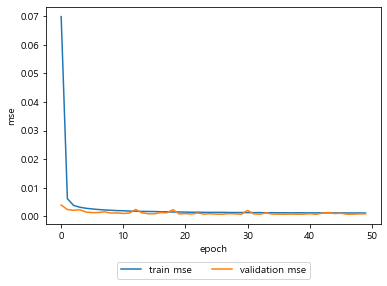

In [598]:
# train mse와 validation mse를 아래와 그립니다.
plt.plot(train_mse, label='train mse')
plt.plot(valid_mse, label='validation mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.15), fancybox=True, shadow=False, ncol=2)

## 예측평가 Seq2Seq(MSE, MAPE)

In [599]:
pred_e1d1 = best_seq2.predict(X_test)

In [605]:
#다시 각 열을 원래 값으로 되돌립니다. inverse_transform을 사용합니다.
for index, i in enumerate(Kepco.columns):
    scaler = scalers['scaler_'+i]
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    y_test[:,:,index] = scaler.inverse_transform(y_test[:,:,index])

In [607]:
# 각 열별 5일치 mse를 다음과 같이 도출했습니다.
for index,i in enumerate(Kepco.columns):
    print(i)
    for j in range(0,5):
        print('Day',test.index[j],':')
        print('MSE:', mean_squared_error(y_test[:,j,index], pred_e1d1[:,j,index]))
    print()
    print()

시가
Day 2018-08-29 00:00:00 :
MSE: 1014598.5953758562
Day 2018-08-30 00:00:00 :
MSE: 1109587.605305182
Day 2018-08-31 00:00:00 :
MSE: 1318560.6005711758
Day 2018-09-03 00:00:00 :
MSE: 1457221.396646561
Day 2018-09-04 00:00:00 :
MSE: 1672656.7044893743


고가
Day 2018-08-29 00:00:00 :
MSE: 1437373.8199863606
Day 2018-08-30 00:00:00 :
MSE: 1246996.6005040177
Day 2018-08-31 00:00:00 :
MSE: 1557766.2833129324
Day 2018-09-03 00:00:00 :
MSE: 1715973.5935228
Day 2018-09-04 00:00:00 :
MSE: 1942080.583757155


저가
Day 2018-08-29 00:00:00 :
MSE: 1360582.1503667643
Day 2018-08-30 00:00:00 :
MSE: 1386549.689647104
Day 2018-08-31 00:00:00 :
MSE: 1536904.5502762157
Day 2018-09-03 00:00:00 :
MSE: 1713969.270412095
Day 2018-09-04 00:00:00 :
MSE: 1977742.7952253765


종가
Day 2018-08-29 00:00:00 :
MSE: 1118456.7745093447
Day 2018-08-30 00:00:00 :
MSE: 1471439.243391999
Day 2018-08-31 00:00:00 :
MSE: 1597535.659629307
Day 2018-09-03 00:00:00 :
MSE: 1768795.546824661
Day 2018-09-04 00:00:00 :
MSE: 2069834.0866

In [608]:
# 각 열별 5일치 MAPE를 다음과 같이 도출했습니다.
for index,i in enumerate(Kepco.columns):
    print(i)
    for j in range(0,5):
        print('Day',test.index[j],':')
        print('MAPE:', mean_absolute_percentage_error(y_test[:,j-1,index], pred_e1d1[:,j-1,index]))
    print()
    print()

시가
Day 2018-08-29 00:00:00 :
MAPE: 0.03868985348483212
Day 2018-08-30 00:00:00 :
MAPE: 0.03560611439764246
Day 2018-08-31 00:00:00 :
MAPE: 0.033613429934764134
Day 2018-09-03 00:00:00 :
MAPE: 0.03487307096444512
Day 2018-09-04 00:00:00 :
MAPE: 0.03591207568681335


고가
Day 2018-08-29 00:00:00 :
MAPE: 0.041131467790337224
Day 2018-08-30 00:00:00 :
MAPE: 0.0416946497553487
Day 2018-08-31 00:00:00 :
MAPE: 0.034252518181841655
Day 2018-09-03 00:00:00 :
MAPE: 0.03746616929906749
Day 2018-09-04 00:00:00 :
MAPE: 0.03874693328825041


저가
Day 2018-08-29 00:00:00 :
MAPE: 0.04355989195118095
Day 2018-08-30 00:00:00 :
MAPE: 0.03903091793253991
Day 2018-08-31 00:00:00 :
MAPE: 0.03658793628272881
Day 2018-09-03 00:00:00 :
MAPE: 0.03752918316115233
Day 2018-09-04 00:00:00 :
MAPE: 0.039573719833979094


종가
Day 2018-08-29 00:00:00 :
MAPE: 0.04336720957905262
Day 2018-08-30 00:00:00 :
MAPE: 0.032088761278879364
Day 2018-08-31 00:00:00 :
MAPE: 0.03705993965732694
Day 2018-09-03 00:00:00 :
MAPE: 0.03726513

## Predict the future 5 days with Attention Technique

In [609]:
# 여기선 seq2에서 만들었던 train세트와 테스트 세트를 그대로 이용할 것입니다.
# 뿐만 아니라 Grid Search를 따로 하지 않고 위에서 구한 LSTM의 최적 Hyperparameter와 
# Seq2Seq2의 최적 Hyperparameter를 합칠 것입니다.
print(grid_lstm.best_params_); print(grid_seq2.best_params_)

{'n_neurons': 20}
{'activation': 'relu'}


In [610]:
n_past= 20
n_features = train.shape[1]
n_future = 5
n_hidden = 20
activation='relu'

In [628]:
X_train, y_train = split_series(series=train.values,n_past=n_past, n_future=n_future, target_col=list(range(len(Kepco.columns))))
test_seq2 = pd.concat([train[-n_past:],test])
X_test, y_test = split_series(series=test_seq2.values,n_past=n_past, n_future=n_future, target_col=list(range(len(Kepco.columns))))

In [614]:
# 여기는 Seq2Seq와 크게 다르지 않습니다.
input_train = Input(shape=(n_past,n_features))
output_train = Input(shape=(n_future, n_features))
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(n_hidden, activation=activation,
                                                      return_state=True, return_sequences=True)(input_train)
decoder_input = RepeatVector(n_future)(encoder_last_h)
decoder_stack_h = LSTM(n_hidden, activation=activation,return_state=False, return_sequences=True)(
decoder_input, initial_state=[encoder_last_h, encoder_last_c])


In [615]:
# Attention Layer를 만듭니다. dot product Attention입니다.
attention_score = dot([decoder_stack_h, encoder_stack_h], axes=[2,2])
attention = Activation('softmax')(attention_score)
context = dot([attention, encoder_stack_h], axes=[2,1])
context = BatchNormalization(momentum=0.6)(context)

In [616]:
# context vector와 decoder hidden value를 하나로 합칩니다.
decoder_combined_context = concatenate([context, decoder_stack_h])

In [617]:
out = TimeDistributed(Dense(n_features))(decoder_combined_context)
model_att = Model(inputs=input_train, outputs=out)
opt= Adam(learning_rate=0.01)
es =EarlyStopping(monitor='val_loss', mode='min', patience=5)
model_att.compile(loss='mse', optimizer=opt, metrics=['mse'])

In [26]:
# 여기선 시간이 여유있길래 epochs를 100으로 했습니다.
history_att = model_att.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[es],
                            verbose=0)

NameError: name 'model_att' is not defined

In [619]:
train_mse = history_att.history['mse']
valid_mse = history_att.history['val_mse']

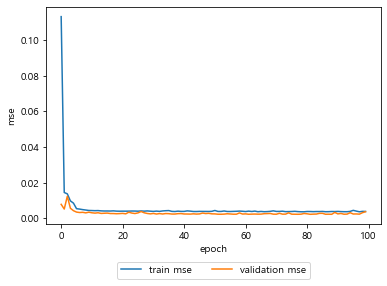

In [620]:
plt.plot(train_mse, label='train mse')
plt.plot(valid_mse, label='validation mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.15), fancybox=True, shadow=False, ncol=2)

## 예측 평가 Attention

In [630]:
# 예측값을 다음과 같이 구합니다.
pred_att = model_att.predict(X_test)

In [631]:
for index, i in enumerate(Kepco.columns):
    scaler = scalers['scaler_'+i]
    pred_att[:,:,index]=scaler.inverse_transform(pred_att[:,:,index])
    y_test[:,:,index] = scaler.inverse_transform(y_test[:,:,index])

In [640]:
# MSE와 MAPE 값 모두 다음과 같습니다.
for index,i in enumerate(Kepco.columns):
    print(i)
    for j in range(0,5):
        print('Day',test.index[j],':')
        print('MSE:', mean_squared_error(y_test[:,j,index], pred_att[:,j,index]))
    print()
    print()

시가
Day 2018-08-29 00:00:00 :
MSE: 4.775843118042468e+23
Day 2018-08-30 00:00:00 :
MSE: 1.0966969243599675e+24
Day 2018-08-31 00:00:00 :
MSE: 1.515013889187949e+24
Day 2018-09-03 00:00:00 :
MSE: 1.660747115713376e+24
Day 2018-09-04 00:00:00 :
MSE: 1.2274430535367463e+25


고가
Day 2018-08-29 00:00:00 :
MSE: 2.1449061441580907e+24
Day 2018-08-30 00:00:00 :
MSE: 3.0677531147532137e+24
Day 2018-08-31 00:00:00 :
MSE: 3.327261978656445e+24
Day 2018-09-03 00:00:00 :
MSE: 1.307145637983495e+24
Day 2018-09-04 00:00:00 :
MSE: 1.2777991682616737e+25


저가
Day 2018-08-29 00:00:00 :
MSE: 7.157860632502564e+22
Day 2018-08-30 00:00:00 :
MSE: 8.958871848173006e+21
Day 2018-08-31 00:00:00 :
MSE: 4.352607133656043e+22
Day 2018-09-03 00:00:00 :
MSE: 1.088046470077083e+24
Day 2018-09-04 00:00:00 :
MSE: 3.55229844333992e+24


종가
Day 2018-08-29 00:00:00 :
MSE: 1.305882230730776e+25
Day 2018-08-30 00:00:00 :
MSE: 1.3304382753956543e+25
Day 2018-08-31 00:00:00 :
MSE: 1.2413348658335142e+25
Day 2018-09-03 00:00:0

In [641]:
for index,i in enumerate(Kepco.columns):
    print(i)
    for j in range(0,5):
        print('Day',test.index[j],':')
        print('MAPE:', mean_absolute_percentage_error(y_test[:,j,index], pred_att[:,j,index]))
    print()
    print()

시가
Day 2018-08-29 00:00:00 :
MAPE: 1282125.3972323048
Day 2018-08-30 00:00:00 :
MAPE: 2038394.4076812472
Day 2018-08-31 00:00:00 :
MAPE: 2071816.1622863852
Day 2018-09-03 00:00:00 :
MAPE: 3194761.2853585333
Day 2018-09-04 00:00:00 :
MAPE: 5575509.697218975


고가
Day 2018-08-29 00:00:00 :
MAPE: 2882177.6179958982
Day 2018-08-30 00:00:00 :
MAPE: 3528119.429440481
Day 2018-08-31 00:00:00 :
MAPE: 2860507.2516640853
Day 2018-09-03 00:00:00 :
MAPE: 2442800.7919132565
Day 2018-09-04 00:00:00 :
MAPE: 5576113.335637452


저가
Day 2018-08-29 00:00:00 :
MAPE: 399484.9378938204
Day 2018-08-30 00:00:00 :
MAPE: 173392.051521373
Day 2018-08-31 00:00:00 :
MAPE: 511226.9741747114
Day 2018-09-03 00:00:00 :
MAPE: 2292093.203471671
Day 2018-09-04 00:00:00 :
MAPE: 3258202.337963168


종가
Day 2018-08-29 00:00:00 :
MAPE: 7199008.310777615
Day 2018-08-30 00:00:00 :
MAPE: 7358987.249681924
Day 2018-08-31 00:00:00 :
MAPE: 6748084.702386416
Day 2018-09-03 00:00:00 :
MAPE: 6544161.71367205
Day 2018-09-04 00:00:00 :
M

## 감사합니다